In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mini_yolov3.model import YOLO
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_target
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes, count_model_parameters, draw_grid
from torchvision.ops import box_convert
from mini_yolov3.evals import calculate_mAP
from torchvision.ops import box_iou
from tqdm import tqdm

/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_dataset = SVHNDataset(split="train", image_size=32)
# train_dataset = Subset(train_dataset, range(12, 13))

In [4]:
train_dataset[0]["bbox"]

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

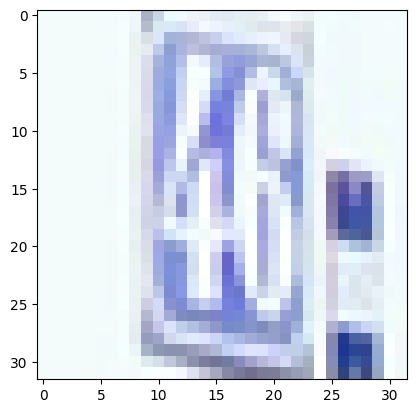

In [5]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

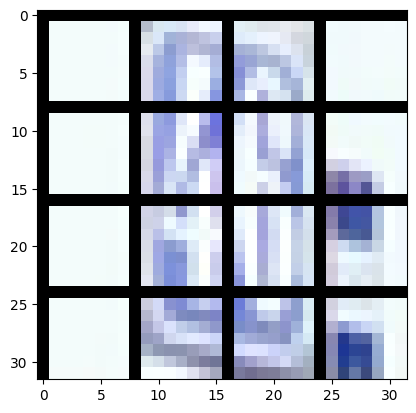

In [6]:
plt.imshow(draw_grid(train_dataset[0]["image"], 32//4))

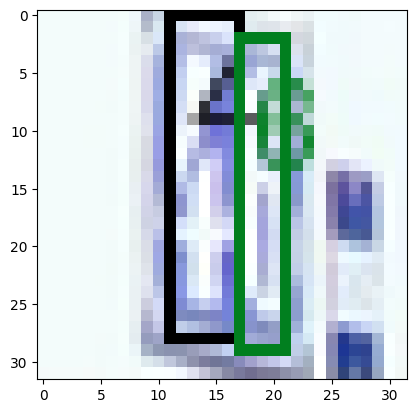

In [7]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [120]:
train_dataset_ = Subset(train_dataset, range(0, 1000))

In [121]:
import json

In [122]:
torch.manual_seed(0)

config = json.load(open("./configs/test.json", "r"))
model = YOLO(**config)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset_,
    num_epochs=200,
    lr=8e-5,
    batch_size=32,
    log_detections=False,
    lambda_coord=5.0,
    lambda_noobj=0.5,
    device="cpu",
    eval_every=100000,
)

In [123]:
trainer.train()

  0%|          | 0/6400 [00:00<?, ?it/s]/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 1/6400 [00:00<05:48, 18.39it/s, class_loss=0.101, coord_loss=1.87, loss=2.98, noobj_loss=0.0135, obj_conf_loss=0.996]/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([62])) that is different to the input size (torch.Size([62, 62])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reducti

KeyboardInterrupt: 

In [112]:
count_model_parameters(model)

716880

In [124]:
dataloader = DataLoader(train_dataset_, batch_size=10, shuffle=False, collate_fn=collate_fn)
batch = next(iter(dataloader))

In [125]:
batch

{'images': tensor([[[[0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
           [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9569, 0.9529],
           [0.9529, 0.9529, 0.9529,  ..., 0.9529, 0.9529, 0.9529],
           ...,
           [0.9529, 0.9529, 0.9529,  ..., 0.5882, 0.9765, 0.9569],
           [0.9529, 0.9529, 0.9529,  ..., 0.5804, 0.9608, 0.9490],
           [0.9608, 0.9608, 0.9608,  ..., 0.5922, 0.9725, 0.9490]],
 
          [[0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9843, 0.9843],
           [0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9882, 0.9843],
           [0.9882, 0.9882, 0.9882,  ..., 0.9843, 0.9843, 0.9843],
           ...,
           [0.9882, 0.9882, 0.9882,  ..., 0.6745, 1.0000, 0.9725],
           [0.9882, 0.9882, 0.9882,  ..., 0.6667, 1.0000, 0.9765],
           [0.9804, 0.9843, 0.9843,  ..., 0.6549, 1.0000, 0.9725]],
 
          [[0.9843, 0.9843, 0.9843,  ..., 0.9922, 0.9922, 0.9922],
           [0.9843, 0.9843, 0.9843,  ..., 0.9922, 0.9961, 0.9922],
           [0.

In [126]:
i = 8

In [127]:
output = model.inference(
    batch["images"],
    confidence_threshold=0.5,
)

bounding_boxes = output.bboxes
bounding_boxes

[{'bboxes': tensor([[0.4483, 0.4617, 0.2333, 0.9063],
          [0.6286, 0.4231, 0.1656, 0.6721],
          [0.5358, 0.4827, 0.4022, 0.7093],
          [0.3921, 0.5007, 0.1675, 0.6589]]),
  'confidence': tensor([1., 1., 1., 1.]),
  'labels': tensor([4, 8, 8, 3]),
  'scores': tensor([0.2994, 0.3543, 0.3543, 0.4473])},
 {'bboxes': tensor([[0.5721, 0.5173, 0.1680, 0.7707],
          [0.3902, 0.4412, 0.2017, 0.6132],
          [0.4394, 0.4632, 0.0536, 0.8074]]),
  'confidence': tensor([1., 1., 1.]),
  'labels': tensor([1, 3, 3]),
  'scores': tensor([0.4495, 0.2904, 0.2904])},
 {'bboxes': tensor([[0.5884, 0.4476, 0.2720, 0.7154],
          [0.4652, 0.5186, 0.2238, 0.5795],
          [0.5553, 0.5372, 0.1312, 0.7218],
          [0.5262, 0.4731, 0.0657, 0.6839]]),
  'confidence': tensor([1., 1., 1., 1.]),
  'labels': tensor([0, 2, 0, 3]),
  'scores': tensor([0.1637, 0.3860, 0.2009, 0.2310])},
 {'bboxes': tensor([[0.4735, 0.5123, 0.1334, 0.2923],
          [0.4438, 0.5349, 0.1684, 0.4962],
    

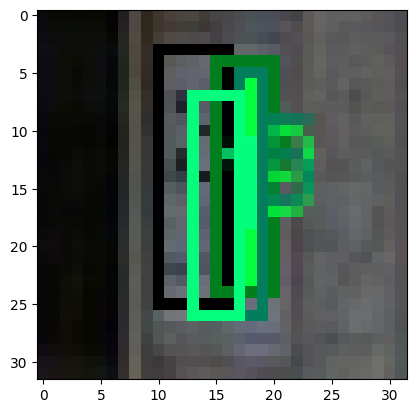

In [129]:
plt.imshow(
    draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
)
)

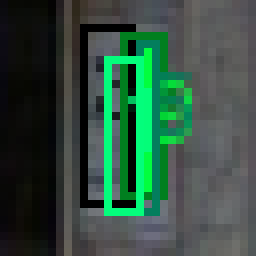

In [130]:
draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
).resize((256, 256), 0)

In [131]:
calculate_mAP(
    model,
    trainer.train_loader,
)

{'map': 0.014527939260005951,
 'map_50': 0.0444815568625927,
 'map_75': 0.005896952003240585,
 'map_small': 0.014527939260005951,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 0.09295850992202759,
 'mar_10': 0.11410428583621979,
 'mar_100': 0.11410428583621979,
 'mar_small': 0.11410428583621979,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [325]:
torch.distributed.is_available()

True